In [2]:
import pandas
import numpy
import pygsheets
import scipy.stats
import datetime

import matplotlib
import matplotlib.pyplot as mp
import seaborn

## colors

In [3]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

## import terminals data from sheet

In [74]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1gAo21abcKUW9r60qWKTAslbMe8vnAZ5voVEFdJ9-aAo') # copy for Jenny's report 2022

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A2')

In [5]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Fuel']!='Oil']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

In [6]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(terms_df_orig['Country'])))
region_list = sorted(list(set(terms_df_orig['Region'])))

## table for exports

In [7]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

mtpa_by_region_export_df = mtpa_by_region_df.copy()

mtpa_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,421.15,39.36,460.51,12.29,444.11,73.90,15.3,1.50,0.0
Eurasia,113.40,19.60,133.00,14.42,16.36,30.60,0.0,0.00,0.0
Sub-Saharan Africa,55.82,13.92,69.74,34.10,27.39,34.32,0.0,0.00,0.0
Middle East and North Africa,63.60,1.07,64.67,22.00,87.75,136.94,0.0,10.40,7.8
SE Asia,19.50,5.80,25.30,1.50,12.55,66.65,0.0,0.00,30.1
Australia and New Zealand,20.10,0.00,20.10,7.20,45.80,87.60,0.0,0.00,0.0
Latin America and the Caribbean,5.37,0.00,5.37,0.00,16.60,16.45,0.0,3.75,0.0
East Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0
Europe,0.00,0.00,0.00,0.00,5.04,4.68,0.0,0.00,0.0
South Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0


## table for imports

In [8]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
# drop all all-zero columns
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-import.xlsx')

mtpa_by_region_import_df = mtpa_by_region_df.copy()
mtpa_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,149.76,91.25,241.01,25.80,54.49,444.10,0.0,1.5,0.0
Europe,139.42,31.18,170.60,14.20,91.24,175.15,0.0,0.0,3.0
South Asia,68.00,33.00,101.00,5.68,80.95,65.20,0.0,0.0,0.0
SE Asia,78.55,21.66,100.21,11.10,28.34,45.05,0.0,0.0,0.0
Latin America and the Caribbean,43.48,12.28,55.76,6.46,16.07,53.36,0.0,0.0,0.0
Sub-Saharan Africa,6.88,1.70,8.58,0.50,7.70,0.11,0.0,0.0,0.0
Australia and New Zealand,3.30,1.90,5.20,0.00,1.75,0.00,0.0,0.0,0.0
Middle East and North Africa,5.15,0.00,5.15,11.10,18.64,48.90,11.8,0.0,0.0
North America,0.05,0.00,0.05,0.00,268.42,81.10,25.0,45.0,17.3
Eurasia,0.00,0.00,0.00,0.00,0.00,12.20,0.0,0.0,0.0


## stacked bar charts for import/export capacity

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_30958/1490074455.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')


Text(0.5, 1.0, 'Regional Export Capacity')

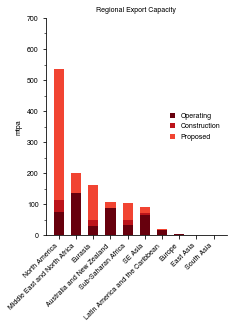

In [10]:
font_size = 7
ytop = 700
set_width=0.6

region_order = mtpa_by_region_export_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_export_df.loc[region_order,:]

fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=font_size)
ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')
ax.set_ylabel('mtpa', size=font_size)

ax.set_ylim(0, ytop)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax.set_title('Regional Export Capacity', fontsize=font_size)

# mp.savefig('saved-figures/regional-export-capacity.png',
#           bbox_inches='tight', 
#           transparent=True,
#           dpi=600)

# mp.savefig('saved-figures/regional-export-capacity.pdf',
#           bbox_inches='tight', 
#           transparent=True)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_30958/1172756596.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')


Text(0.5, 1.0, 'regional import capacity')

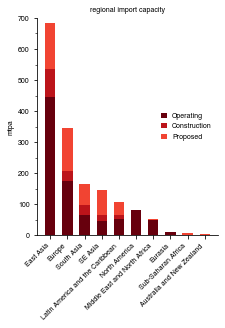

In [12]:
font_size = 7
ytop = 700
set_width=0.6

region_order = mtpa_by_region_import_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_import_df.loc[region_order,:]

fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=font_size)
ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_ylim(0, ytop)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax.set_title('regional import capacity', fontsize=font_size)

# mp.savefig('saved-figures/regional-import-capacity.png',
#           bbox_inches='tight', 
#           transparent=True,
#           dpi=600)

# mp.savefig('saved-figures/regional-import-capacity.pdf',
#           bbox_inches='tight', 
#           transparent=True)

## export and import capacity over time

## import

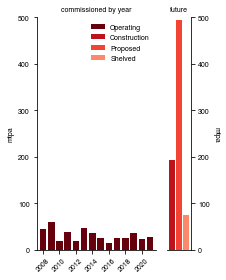

In [14]:
mtpa_started_sum = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['Import/Export']=='Import')&
                                     (terms_df_orig.Status=='Operating')].groupby('StartYearEarliest')['CapacityInMtpa'].sum()
#terms_df_orig.groupby('StartYearEarliest')['CapacityInMtpa'].sum()

# indev pipelines = Proposed or Construction
mtpa_indev = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['Import/Export']=='Import')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7

ytop = 500
ytop2 = 500

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(mtpa_started_sum.index.values[-15:-1], mtpa_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, mtpa_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('mtpa', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

# mp.savefig('saved-figures/mtpa-import-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-import-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

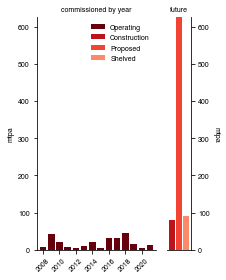

In [15]:
mtpa_started_sum = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['Import/Export']=='Export')&
                                     (terms_df_orig.Status=='Operating')].groupby('StartYearEarliest')['CapacityInMtpa'].sum()
#terms_df_orig.groupby('StartYearEarliest')['CapacityInMtpa'].sum()

# indev pipelines = Proposed or Construction
mtpa_indev = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['Import/Export']=='Export')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7

ytop = 625
ytop2 = 625

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(mtpa_started_sum.index.values[-15:-1], mtpa_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, mtpa_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('mtpa', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

# mp.savefig('saved-figures/mtpa-export-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-export-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

# redo fig above with big bars for each, not year-by-year

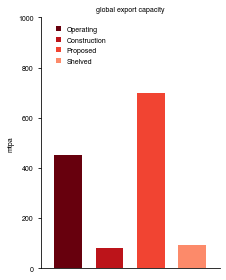

In [16]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['Import/Export']=='Export')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 1000
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('global export capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

# mp.savefig('saved-figures/mtpa-export-summed-bars.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-export-summed-bars.pdf', bbox_inches='tight', transparent=True)

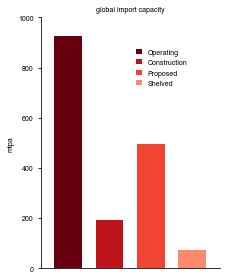

In [17]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['Import/Export']=='Import')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 1000
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.5,0.9))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('global import capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

# mp.savefig('saved-figures/mtpa-import-summed-bars.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-import-summed-bars.pdf', bbox_inches='tight', transparent=True)

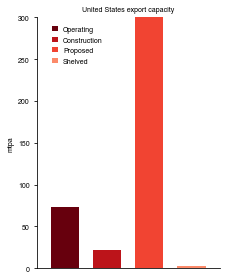

In [18]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['Import/Export']=='Export')&
                                          (terms_df_orig.Country=='United States')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 300
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('United States export capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

# mp.savefig('saved-figures/mtpa-export-summed-bars-US-only.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-export-summed-bars-US-only.pdf', bbox_inches='tight', transparent=True)

# (new) plot of import/export for 2021, 2022, future

In [19]:
#shelved_2021_2022
shelved_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Export')&
                                   (terms_df_orig.Status=='Shelved')&
                                   (terms_df_orig.ShelvedYear.isin([2021,2022]))]['CapacityInMtpa'].sum(min_count=0)

shelved_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Import')&
                                   (terms_df_orig.Status=='Shelved')&
                                   (terms_df_orig.ShelvedYear.isin([2021,2022]))]['CapacityInMtpa'].sum(min_count=0)

#cancelled_2021_2022

cancelled_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Export')&
                                   (terms_df_orig.Status=='Cancelled')&
                                   (terms_df_orig.CancelledYear.isin([2021,2022]))]['CapacityInMtpa'].sum(min_count=0)

cancelled_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Import')&
                                   (terms_df_orig.Status=='Cancelled')&
                                   (terms_df_orig.CancelledYear.isin([2021,2022]))]['CapacityInMtpa'].sum(min_count=0)

#construction (present)
construction_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Export')&
                                   (terms_df_orig.Status=='Construction')]['CapacityInMtpa'].sum(min_count=0)

construction_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Import')&
                                   (terms_df_orig.Status=='Construction')]['CapacityInMtpa'].sum(min_count=0)

#proposed (present)
proposed_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Export')&
                                   (terms_df_orig.Status=='Proposed')]['CapacityInMtpa'].sum(min_count=0)

proposed_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Import')&
                                   (terms_df_orig.Status=='Proposed')]['CapacityInMtpa'].sum(min_count=0)

In [20]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [21]:
adjust_lightness('#fee948', amount=1)

(0.9960784313725491, 0.9137254901960785, 0.28235294117647036)

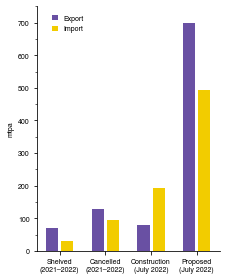

In [22]:
font_size = 7
ytop = 750
#fig = mp.figure(figsize=(3.25,4))
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_ylim(0, ytop)
ax.set_xlim(0,12)
xvals = [1,2,4,5,7,8,10,11]

export_color = matplotlib.cm.get_cmap('Purples')(0.75)
#import_color = adjust_lightness('#fee948', amount=0.75)
import_color = adjust_lightness('gold', amount=0.95)
#'gold'#matplotlib.cm.get_cmap('YlRdBr')(0.75)

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

# colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
# status = ['Operating', 'Construction', 'Proposed', 'Shelved']
# ax_list = []
# for x,c,s in zip(xvals,colors,status):
#     ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
#              color=c, label=s, width=0.666))
# shelved
ax.bar(xvals[0], shelved_export,
       color=export_color)

ax.bar(xvals[1], shelved_import,
       color=import_color)

# cancelled
ax.bar(xvals[2], cancelled_export,
       color=export_color)

ax.bar(xvals[3], cancelled_import,
       color=import_color)

# construction
ax.bar(xvals[4], construction_export,
       color=export_color)

ax.bar(xvals[5], construction_import,
       color=import_color)

# proposed
ax.bar(xvals[6], proposed_export,
       color=export_color,
       label='Export')

ax.bar(xvals[7], proposed_import,
       color=import_color,
       label='Import')

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks([1.5,4.5,7.5,10.5])
ax.set_xticklabels(['Shelved\n(2021–2022)',
                    'Cancelled\n(2021–2022)',
                    'Construction\n(July 2022)',
                    'Proposed\n(July 2022)'])

#ax.set_title('United States export capacity', fontsize=font_size)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
fig.tight_layout()#w_pad=0.05)

ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

# mp.savefig('saved-figures/export-import-all-statuses-goldpurple.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/export-import-all-statuses-goldpurple.pdf', bbox_inches='tight', transparent=True)

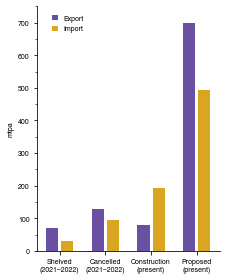

In [24]:
font_size = 7
ytop = 750
#fig = mp.figure(figsize=(3.25,4))
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_ylim(0, ytop)
ax.set_xlim(0,12)
xvals = [1,2,4,5,7,8,10,11]

export_color = matplotlib.cm.get_cmap('Purples')(0.75)
import_color = 'goldenrod'#matplotlib.cm.get_cmap('YlRdBr')(0.75)

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

# colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
# status = ['Operating', 'Construction', 'Proposed', 'Shelved']
# ax_list = []
# for x,c,s in zip(xvals,colors,status):
#     ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
#              color=c, label=s, width=0.666))
# shelved
ax.bar(xvals[0], shelved_export,
       color=export_color)

ax.bar(xvals[1], shelved_import,
       color=import_color)

# cancelled
ax.bar(xvals[2], cancelled_export,
       color=export_color)

ax.bar(xvals[3], cancelled_import,
       color=import_color)

# construction
ax.bar(xvals[4], construction_export,
       color=export_color)

ax.bar(xvals[5], construction_import,
       color=import_color)

# proposed
ax.bar(xvals[6], proposed_export,
       color=export_color,
       label='Export')

ax.bar(xvals[7], proposed_import,
       color=import_color,
       label='Import')

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks([1.5,4.5,7.5,10.5])
ax.set_xticklabels(['Shelved\n(2021–2022)',
                    'Cancelled\n(2021–2022)',
                    'Construction\n(present)',
                    'Proposed\n(present)'])

#ax.set_title('United States export capacity', fontsize=font_size)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
fig.tight_layout()#w_pad=0.05)

ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

# mp.savefig('saved-figures/export-import-all-statuses-darkgoldpurple.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/export-import-all-statuses-darkgoldpurple.pdf', bbox_inches='tight', transparent=True)

# pie chart of emissions

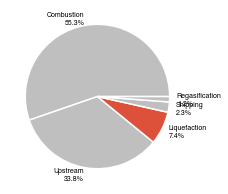

In [25]:
emissions_labels = ['Combustion', 
                    'Upstream',
                    'Liquefaction',
                    'Shipping',
                    'Regasification']
#emissions_percents = numpy.array((364,223,49,15,8))/659*100.
emissions_percents = [55.3,33.8,7.4,2.3,1.2] # round the first one from 55.2 to 55.3 to make it sum to 100

font_size=7

fig = mp.figure(figsize=(3.25,3.25))
ax = fig.add_subplot(111)

nwedges = 5 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_import_df.index[:nwedges]
pie_vals = emissions_percents

pie_labels = []
for i in range(emissions_labels.__len__()):
    pie_labels.append(emissions_labels[i]+
                      '\n'+f'{emissions_percents[i]:.1f}%')

# pie_labels_mtpa = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
#pie_labels_perc = (mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'] / 
#                  mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
# pie_labels_cost = cost_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************

sel_cmap = matplotlib.cm.get_cmap('Greys')
#wedge_colors = sel_cmap(numpy.linspace(0.5,0.2,nwedges))
wedge_colors = ['0.75']*5
wedge_colors[2] = matplotlib.cm.get_cmap('inferno')(0.6)

# ****************************************

ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=wedge_colors,#colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),,
       wedgeprops=dict(edgecolor='1', linewidth=1.5),#, width=pie_width),
       textprops={'fontsize': font_size})

ax.tick_params(labelsize=font_size)

fig.tight_layout()

# mp.savefig('saved-figures/emissions-pie.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/emissions-pie.pdf', bbox_inches='tight', transparent=True)


# reproduce Clark Williams-Derry's plot

In [26]:
terms_df_cwd = terms_df_orig.loc[terms_df_orig.ExportFigureClarkWilliamsDerry=='yes']

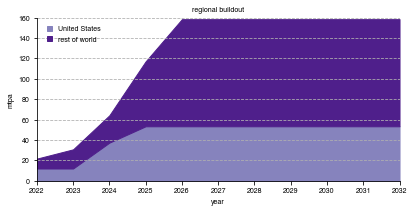

In [27]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_usa = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_cwd_subset = terms_df_cwd.loc[(terms_df_cwd.StartYearEarliest==year_list[yr_idx])]
    mtpa_sum[yr_idx:] += terms_df_cwd_subset['CapacityInMtpa'].sum()
    
    terms_df_cwd_subset_usa = terms_df_cwd.loc[(terms_df_cwd.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_cwd.Country=='United States')]
    mtpa_sum_usa[yr_idx:] += terms_df_cwd_subset_usa['CapacityInMtpa'].sum()

font_size = 7
fig = mp.figure(figsize=(6.5,3))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,160)

sel_cmap = matplotlib.cm.get_cmap('Purples')
color_light = sel_cmap(0.6)
color_dark = sel_cmap(0.9)
ax.fill_between(year_list, mtpa_sum_usa, 0, label='United States', color=color_light)
ax.fill_between(year_list, mtpa_sum, mtpa_sum_usa, label='rest of world', color=color_dark)

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# mp.savefig('saved-figures/mtpa-export-usa-non-usa-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-export-usa-non-usa-timeseries.pdf', bbox_inches='tight', transparent=True)

## color coordinate by region

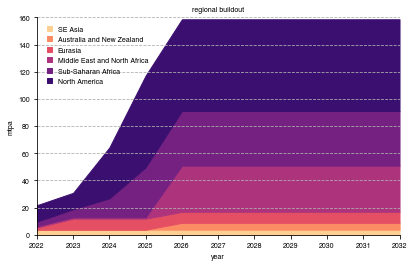

In [28]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)

for yr_idx in range(year_list.__len__()):
    terms_df_cwd_subset = terms_df_cwd.loc[terms_df_cwd.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_cwd_subset.groupby('Region')['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

font_size = 7
fig = mp.figure(figsize=(6.5,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,160)

new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.9,0.2,new_region_list.__len__())]

for region_idx in range(new_region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        0, color=region_colors[region_idx], label=new_region_list[region_idx])
    else:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx]],
                        mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx-1]], 
                        color=region_colors[region_idx], label=new_region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# mp.savefig('saved-figures/mtpa-export-regional-timeseries-CWD.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-export-regional-timeseries-CWD.pdf', bbox_inches='tight', transparent=True)

# our version of Clark Williams-Derry's plot (using Rob's column)

In [29]:
terms_df_cwd2 = terms_df_orig.loc[terms_df_orig.Construction_Sanctioned_July_2022=='yes']

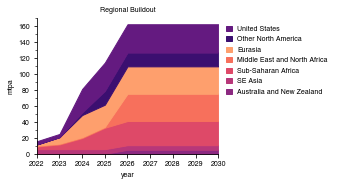

In [30]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_usa = numpy.zeros(year_list.__len__())
#pandas.DataFrame(0.0, index=year_list, columns='United States')#numpy.zeros(year_list.__len__())
#mtpa_sum_rest_of_nam = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_cwd2_subset = terms_df_cwd2.loc[terms_df_cwd2.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_cwd2_subset.groupby('Region')['CapacityInMtpa'].sum()
    
    terms_df_cwd_subset_usa = terms_df_cwd2.loc[(terms_df_cwd2.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_cwd2.Country=='United States')]
    mtpa_sum_usa[yr_idx:] += terms_df_cwd_subset_usa['CapacityInMtpa'].sum()
    #mtpa_sum_usa.loc[year_list[yr_idx], 'United States'] = terms_df_dwd

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

mtpa_sum_rest_of_nam = mtpa_sum_regional_cumsum['North America'].values - mtpa_sum_usa

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))
#fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,170)

new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.4,0.8,new_region_list.__len__()-1)]

for region_idx in range(new_region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        color=region_colors[region_idx], 
                        label=new_region_list[region_idx])
    else:
        if new_region_list[region_idx]=='North America':
            #pass
            #do the north america not USA chunk
            ax.fill_between(year_list, 
                        mtpa_sum_regional_cumsum_byregion['Eurasia'], 
                        mtpa_sum_regional_cumsum_byregion['Eurasia']+mtpa_sum_rest_of_nam,
                        color=matplotlib.cm.get_cmap('magma')(0.2), 
                        label='Other North America')
            ax.fill_between(year_list,
                        mtpa_sum_regional_cumsum_byregion['Eurasia']+mtpa_sum_rest_of_nam,
                        mtpa_sum_regional_cumsum_byregion['Eurasia']+mtpa_sum_rest_of_nam+mtpa_sum_usa,
                        color=matplotlib.cm.get_cmap('magma')(0.3), 
                        label='United States')   
        
        else:
            ax.fill_between(year_list, 
                        mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx-1]],
                        mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx]], 
                        color=region_colors[region_idx], 
                        label=new_region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
#ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
#ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# mp.savefig('saved-figures/mtpa-export-regional-timeseries-Construction_Sanctioned_July_2022.png', bbox_inches='tight', transparent=True, dpi=600)
# mp.savefig('saved-figures/mtpa-export-regional-timeseries-Construction_Sanctioned_July_2022.pdf', bbox_inches='tight', transparent=True)

# cost calculations

## create offshore and floating dfs

In [31]:
# insane outliers
# Ravenna - T068300
# Gorgon LNG (megaproject) - T068300
# Tanzania LNG Terminal trains 1, 2 - T026301, T026302
# Coral South FLNG Terminal - includes deep gas well construction - T025801
outlier_comboids = ['T068300','T068300','T026301','T026302','T025801']

In [32]:
terms_df_floating = terms_df_orig.loc[terms_df_orig.Floating=='yes']
terms_df_onshore = terms_df_orig.loc[terms_df_orig.Floating=='']

#terms_df_floating = terms_df_floating.loc[~terms_df_floating.ComboID.isin(outlier_comboids)]
#terms_df_onshore = terms_df_onshore.loc[~terms_df_onshore.ComboID.isin(outlier_comboids)]
terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

In [33]:
terms_df_floating_noexpansions = terms_df_floating.loc[~terms_df_floating['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')
terms_df_onshore_noexpansions = terms_df_onshore.loc[~terms_df_onshore['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')

## count for Scott - how many per region do we currently have?

## import

In [34]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Tema FSRU,Ghana,Construction,https://www.gem.wiki/Tema_FSRU,205882352.900000
Coega FSRU,South Africa,Proposed,https://www.gem.wiki/Coega_FSRU,500000000.000000
Kutubdia (Reliance) FSRU,Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_(Reliance)_FSRU,84444444.300000
Moheshkhali FLNG Terminal (Petrobangla),Bangladesh,Operating,https://www.gem.wiki/Moheshkhali_FLNG_Terminal_(Petrobangla),47236842.100000
Jawa Satu FSRU,Indonesia,Operating,https://www.gem.wiki/Jawa_Satu_FSRU,145833333.300000
Newcastle FSRU,Australia,Proposed,https://www.gem.wiki/Newcastle_FSRU,406410000.000000
Eagle FLNG Terminal,Albania,Cancelled,https://www.gem.wiki/Eagle_FLNG_Terminal,140740740.700000
Krk FSRU,Croatia,Operating,https://www.gem.wiki/Krk_FSRU,124887381.400000
Cyprus LNG Terminal,Cyprus,Construction,https://www.gem.wiki/Cyprus_LNG_Terminal,592800000.000000
Wilhelmshaven FSRU,Germany,Construction,https://www.gem.wiki/Wilhelmshaven_FSRU,93023991.300000


In [35]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Jorf Lasfar LNG Terminal,Morocco,Proposed,https://www.gem.wiki/Jorf_Lasfar_LNG_Terminal,874285632.700000
Kutubdia LNG Terminal (Petronet),Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_LNG_Terrminal_(Petronet),84444444.400000
Lahad Datu Sabah LNG Terminal,Malaysia,Cancelled,https://www.gem.wiki/Lahad_Datu_Sabah_LNG_Terminal,317105263.200000
Pengerang Johor LNG Terminal,Malaysia,Operating,https://www.gem.wiki/Pengerang_Johur_LNG_Terminal,169714285.700000
Gwadar LNG Terminal,Pakistan,Proposed,https://www.gem.wiki/Gwadar_LNG_Terminal,630136986.300000
Singapore LNG Terminal,Singapore,Operating,https://www.gem.wiki/Singapore_LNG_Terminal,154545454.500000
Boryeong LNG Terminal,South Korea,Operating,https://www.gem.wiki/Boryeong_LNG_Terminal,144210000.000000
Samcheok LNG Terminal,South Korea,Operating,https://www.gem.wiki/Samcheok_LNG_Terminal,132222222.200000
Kerewalapitiya LNG Terminal,Sri Lanka,Shelved,https://www.gem.wiki/Kerewalapitiya_LNG_Terminal,92592592.600000
Taichung LNG Terminal,Taiwan,Operating,https://www.gem.wiki/Taichung_LNG_Terminal,357000000.000000


## export list

In [36]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,583333333.300000
Cameroon FLNG Terminal,Cameroon,Operating,https://www.gem.wiki/Cameroon_FLNG_Terminal,500000000.000000
Fortuna FLNG Terminal,Equatorial Guinea,Cancelled,https://www.gem.wiki/Fortuna_FLNG_Terminal,793650793.700000
Cedar FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Cedar_FLNG_Terminal,800000000.000000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.100000
Greater Tortue Ahmeyim FLNG Terminal,Mauritania,Construction,https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,463680000.000000
Etinde FLNG Terminal,Cameroon,Proposed,https://www.gem.wiki/Etinde_FLNG_Terminal,384615384.600000
Ksi Lisims FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Ksi_Lisims_FLNG_Terminal,833333333.300000
New Fortress Grand Isle FLNG Terminal,United States,Proposed,https://www.gem.wiki/New_Fortress_Grand_Isle_FLNG_Terminal,500000000.000000


In [37]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Eagle LNG Terminal,United States,Proposed,https://www.gem.wiki/Eagle_LNG_Terminal,547474747.500000
G2 LNG Terminal,United States,Proposed,https://www.gem.wiki/G2_LNG_Terminal,846153846.200000
Golden Pass LNG Terminal,United States,Construction,https://www.gem.wiki/Golden_Pass_LNG,552486187.800000
Gulf LNG Terminal,United States,Proposed,https://www.gem.wiki/Gulf_LNG,736648250.500000
Port Arthur LNG Terminal,United States,Proposed,https://www.gem.wiki/Point_Arthur_LNG_Terminal,62962963.000000
Plaquemines LNG Terminal,United States,Proposed,https://www.gem.wiki/Venture_Global_Plaquemines_LNG_Terminal,990247561.900000
Egyptian LNG Terminal,Egypt,Operating,https://www.gem.wiki/ELNG_IDCO_Terminal,311111111.100000
Punta Europa LNG Terminal,Equatorial Guinea,Operating,https://www.gem.wiki/Punta_Europa_LNG_Terminal,405405405.400000
Mozambique LNG Terminal,Mozambique,Shelved,https://www.gem.wiki/Mozambique_LNG_Terminal,775193798.400000


### make dataframe to use for terminal calculations

* regional averages for onshore terminals
  * fewer than 3 data points, then apply a global value rather than a regional one!
* global averages for offshore terminals

In [71]:
onshore_export_regional_costs = pandas.DataFrame(index=region_list)

onshore_export_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_export_regional_costs.loc[(onshore_export_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
print('export onshore')
onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = onshore_export_regional_costs['RegionalCostUSDPerMtpa']/1e6
onshore_export_regional_costs

export onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,4.00000,594.99536
East Asia,NaN,589.21772
Eurasia,1.00000,589.21772
Europe,NaN,589.21772
Latin America and the Caribbean,3.00000,523.91812
Middle East and North Africa,6.00000,544.76712
North America,12.00000,577.97338
SE Asia,1.00000,589.21772
South Asia,NaN,589.21772
Sub-Saharan Africa,5.00000,623.59524


In [70]:
onshore_import_regional_costs = pandas.DataFrame(index=region_list)

onshore_import_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_import_regional_costs.loc[(onshore_import_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
print('import onshore')
onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = onshore_import_regional_costs['RegionalCostUSDPerMtpa']/1e6
onshore_import_regional_costs

import onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,1.00000,269.68935
East Asia,15.00000,351.63857
Eurasia,NaN,269.68935
Europe,15.00000,232.51061
Latin America and the Caribbean,4.00000,310.48545
Middle East and North Africa,2.00000,269.68935
North America,2.00000,269.68935
SE Asia,11.00000,185.18412
South Asia,5.00000,255.77629
Sub-Saharan Africa,NaN,269.68935


In [72]:
floating_export_regional_costs = pandas.DataFrame(index=region_list)

floating_export_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_export_regional_costs.loc[:,
                                #(floating_export_regional_costs.NumberOfDataPoints<3) | 
                                #  (floating_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
print('export floating')
floating_export_regional_costs['RegionalCostUSDPerMtpa'] = floating_export_regional_costs['RegionalCostUSDPerMtpa']/1e6
floating_export_regional_costs

export floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,NaN,567.47286
East Asia,NaN,567.47286
Eurasia,1.00000,567.47286
Europe,NaN,567.47286
Latin America and the Caribbean,NaN,567.47286
Middle East and North Africa,NaN,567.47286
North America,4.00000,567.47286
SE Asia,NaN,567.47286
South Asia,NaN,567.47286
Sub-Saharan Africa,4.00000,567.47286


In [73]:
floating_import_regional_costs = pandas.DataFrame(index=region_list)

floating_import_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_import_regional_costs.loc[:,
                                   #(floating_import_regional_costs.NumberOfDataPoints<3) | 
                                  #(floating_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
print('import floating')
floating_import_regional_costs['RegionalCostUSDPerMtpa'] = floating_import_regional_costs['RegionalCostUSDPerMtpa']/1e6
floating_import_regional_costs

import floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,3.00000,137.64766
East Asia,NaN,137.64766
Eurasia,NaN,137.64766
Europe,14.00000,137.64766
Latin America and the Caribbean,3.00000,137.64766
Middle East and North Africa,NaN,137.64766
North America,NaN,137.64766
SE Asia,4.00000,137.64766
South Asia,8.00000,137.64766
Sub-Saharan Africa,2.00000,137.64766


### global calculations

In [42]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_error = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

In [43]:
cost_onshore_export

array([5.89217718e+08])

In [44]:
cost_floating_export

array([5.67472856e+08])

In [45]:
cost_onshore_import

array([2.69689349e+08])

In [46]:
cost_floating_import

array([1.3764766e+08])

### calculate how much export/import capacity data we have

In [47]:
terms_df_costs_exist = terms_df_orig.loc[~terms_df_orig.CostUSDPerMtpa.isnull()]
terms_df_costs_exist.to_excel('available-cost-data.xlsx', index=False)

In [48]:
#% of import terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Import')].shape)
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Import')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(510/587 * 100)

(607, 76)
(516, 76)
86.88245315161839


In [49]:
#% of export terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Export')].shape)
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Export')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(542/560 * 100)

(567, 76)
(548, 76)
96.78571428571429


In [50]:
floating_import_regional_costs.loc['Australia and New Zealand','RegionalCostUSDPerMtpa']

137647660.13235292

## now calculate the import terminal costs

In [51]:
terms_df_import = terms_df_orig.loc[terms_df_orig['Import/Export']=='Import']

terms_df_import['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    floating_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    onshore_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostEstUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostEstUSD']

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_30958/2744612308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_import['CostUSDTotal'] = numpy.nan
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## and calculate export terminal costs

In [52]:
terms_df_export = terms_df_orig.loc[terms_df_orig['Import/Export']=='Export']

terms_df_export['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    floating_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    onshore_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostEstUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostEstUSD']

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_30958/498498827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_export['CostUSDTotal'] = numpy.nan


## import terminal costs table

In [53]:
#mtpa by country
cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Country')['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Region')['CostUSDTotal'].sum()

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_import_df.index:
    cost_by_region_import_df.drop(index='Total', inplace=True)   
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

else:
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

# total
if 'Total' in cost_by_country_import_df.index:
    cost_by_country_import_df.drop(index='Total', inplace=True)   
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

else:
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
cost_by_country_import_df.to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df/1e9

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,49.999150,31.296423,81.295573,7.144935,18.518813,154.534518,0.000000,0.527458,0.000000
Europe,26.259428,3.561384,29.820813,3.129799,18.624343,39.695091,0.000000,0.000000,0.412943
SE Asia,18.148108,2.733742,20.881850,3.698259,7.215494,6.982052,0.000000,0.000000,0.000000
South Asia,11.548361,6.539450,18.087811,0.924543,15.682637,14.250795,0.000000,0.000000,0.000000
Latin America and the Caribbean,4.636187,1.690313,6.326500,0.889204,4.384569,8.812590,0.000000,0.000000,0.000000
Middle East and North Africa,4.500000,0.000000,4.500000,1.527889,5.027009,8.571677,1.624242,0.000000,0.000000
Sub-Saharan Africa,3.177601,0.350000,3.527601,0.068824,1.059887,0.015141,0.000000,0.000000,0.000000
Australia and New Zealand,0.716910,0.172500,0.889410,0.000000,0.172500,0.000000,0.000000,0.000000,0.000000
North America,0.013484,0.000000,0.013484,0.000000,64.828924,20.459890,6.346109,12.136021,4.665626
Eurasia,0.000000,0.000000,0.000000,0.000000,0.000000,2.933697,0.000000,0.000000,0.000000


## export terminal costs table

In [54]:
#mtpa by country
cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Country')['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Region')['CostUSDTotal'].sum()

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_export_df.index:
    cost_by_region_export_df.drop(index='Total', inplace=True)   
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

else:
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

# total
if 'Total' in cost_by_country_export_df.index:
    cost_by_country_export_df.drop(index='Total', inplace=True)   
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

else:
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
cost_by_country_export_df.to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df/1e9

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,291.079718,30.201867,321.281585,11.164123,255.674029,42.712233,8.842993,0.866960,0.000000
Eurasia,71.044626,19.100000,90.144626,14.918846,11.678511,18.030062,0.000000,0.000000,0.000000
Sub-Saharan Africa,73.680642,15.001305,88.681947,24.680967,17.401679,26.993814,0.000000,0.000000,0.000000
Middle East and North Africa,54.317129,0.582901,54.900029,11.984877,58.593035,68.074428,0.000000,5.665578,4.249184
SE Asia,36.551966,2.378435,38.930402,0.883827,12.031095,55.565653,0.000000,0.000000,17.735453
Australia and New Zealand,28.301483,0.000000,28.301483,17.250000,30.920755,176.846423,0.000000,0.000000,0.000000
Latin America and the Caribbean,10.000000,0.000000,10.000000,0.000000,8.740743,6.481188,0.000000,0.974175,0.000000
East Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Europe,0.000000,0.000000,0.000000,0.000000,6.000000,6.182825,0.000000,0.000000,0.000000
South Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# calculate what Jenny needs for gas plants report

In [55]:
cost_by_country_export_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
United States,2.010470e+11,1.232345e+10,2.133705e+11,1.164123e+09,9.425091e+10,4.268333e+10,8.842993e+09,8.669601e+08,0.000000e+00
Russia,7.104463e+10,1.910000e+10,9.014463e+10,1.491885e+10,1.167851e+10,1.791222e+10,0.000000e+00,0.000000e+00,0.000000e+00
Canada,5.586079e+10,1.600000e+10,7.186079e+10,1.000000e+10,1.585332e+11,2.889867e+07,0.000000e+00,0.000000e+00,0.000000e+00
Qatar,4.625000e+10,0.000000e+00,4.625000e+10,0.000000e+00,0.000000e+00,3.907178e+10,0.000000e+00,0.000000e+00,0.000000e+00
Mexico,3.417192e+10,1.878413e+09,3.605034e+10,0.000000e+00,2.889867e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Mozambique,2.400000e+10,7.000000e+09,3.100000e+10,2.000000e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Tanzania,3.000000e+10,0.000000e+00,3.000000e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Australia,2.830148e+10,0.000000e+00,2.830148e+10,1.725000e+10,3.092075e+10,1.768464e+11,0.000000e+00,0.000000e+00,0.000000e+00
Indonesia,2.000000e+10,2.378435e+09,2.237844e+10,0.000000e+00,1.738192e+09,1.370379e+10,0.000000e+00,0.000000e+00,1.773545e+10
Nigeria,1.069236e+10,6.842105e+09,1.753447e+10,0.000000e+00,1.371910e+10,1.429381e+10,0.000000e+00,0.000000e+00,0.000000e+00


In [61]:
country_list_gas_plants_report = ['China',
                                  'Vietnam',
                                  'Indonesia',
                                  'India',
                                  'Bangladesh',
                                  'South Korea',
                                  'Philippines',
                                  'Japan']

pandas.options.display.float_format = '{:,.5f}'.format
cost_by_country_export_df.loc[cost_by_country_export_df.index.isin(country_list_gas_plants_report)][['Proposed','Construction']]/1e9

,Proposed,Construction
Indonesia,20.00000,2.37844


In [64]:
country_list_gas_plants_report = ['China',
                                  'Vietnam',
                                  'Indonesia',
                                  'India',
                                  'Bangladesh',
                                  'South Korea',
                                  'Philippines',
                                  'Japan']

pandas.options.display.float_format = '{:,.5f}'.format
cost_by_country_import_df.loc[cost_by_country_import_df.index.isin(country_list_gas_plants_report)].reindex(country_list_gas_plants_report)[['Proposed','Construction']]/1e9

,Proposed,Construction
China,42.93122,29.18659
Vietnam,6.74438,0.84055
Indonesia,1.49984,0.07407
India,4.99868,6.53945
Bangladesh,2.95756,0.00000
South Korea,4.07901,0.00000
Philippines,1.16418,0.77962
Japan,0.00000,0.00000
